# Lecture 8 - More Hierarchical Modelling and MCMC Diagnostics

## Today's Learning Objectives

1. Apply Bayesian hierarchical modelling in a more complex case.
2. Formulate the Bayesian modelling setup in this complex case.
3. Interpret the simulation results in function of the initial statistical inquiries.
4. Evaluate Markov Chain Monte Carlo (MCMC) posterior sampling via model diagnostics.

## Loading `R` Packages

In [1]:
options(repr.matrix.max.rows = 8)
library(bayesrules)
library(tidyverse)
library(rstan)
library(bayesplot)
library(cowplot)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: StanHeaders




rstan version 2.32.6 (Stan version 2.32.2)




For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)





Attaching package: ‘rstan’




The following object is masked from ‘package:tidyr’:

    extract




This is bayesplot version 1.11.1



- Online documentation and vignettes at mc-stan.org/bayesplot



- bayesplot theme set to bayesplot::theme_default()



   * Does _not_ affect other ggplot2 plots



   * See ?bayesplot_theme_set for details on theme setting




Attaching package: ‘cowplot’




The following object is masked from ‘package:lubridate’:

    stamp




## 1. The Spotify Dataset

We will explore the `spotify` dataset from the `bayesrules` package. This dataset is a sample of $n = 350$ songs with different variables by column. **The songs belong to 44 different artists.** The package's description is the following:

> *A sub-sample of the Spotify song data originally collected by Kaylin Pavlik (kaylinquest) and distributed through the `R` for Data Science TidyTuesday project.*

<center>        
<img src="https://storage.googleapis.com/pr-newsroom-wp/1/2018/11/Spotify_Logo_CMYK_Green.png" width="600" height="180"/>
</center>

### If you like dancing, you might wonder: how danceable Spotify's songs are?

### 1.1. Main Statistical Inquiries

Firstly, let us formally define our main statistical inquiries:

1. **Assuming the `spotify` sample is representative enough**, what is the overall **mean danceability** for the songs on the platform?
2. **Assuming the `spotify` sample is representative enough of the 44 artists' discography**, how danceable is their music compared to the **overall mean danceability** of the songs in the platform?

```{note}
This exercise is based on [Chapter 16 from Bayes Rules!](https://www.bayesrulesbook.com/chapter-16.html) textbook. However, they play around with a popularity index. Hence, let us make everything more danceable.
```

### 1.2. Data Wrangling

The raw dataset has 23 columns, but our Bayesian model will be restricted to two of the them:

- `artist`: song artist (a factor-type variable with 44 levels).
- `danceability`: a continuous score from 0 (not danceable) to 100 (danceable) based on features such as tempo, rhythm, etc.

In [2]:
# Creating training set.
spotify_training <-spotify |>
  select(artist, danceability)
spotify_training

artist,danceability
<fct>,<dbl>
Alok,74.7
Alok,70.7
Alok,77.8
Alok,68.2
⋮,⋮
Zeds Dead,65.9
Zeds Dead,60.4
Zeds Dead,50.1
Zeds Dead,67.5


As in the baseball problem from `lab2`, we will have an **ID catalogue for artists**. Hence, we create a catalogue of artist names and assign numerical codes from `1` to `44` by alphabetical order. We will use this catalogue in our Bayesian results later on.

In [3]:
artist_catalogue <- tibble(
  artist = levels(spotify_training$artist),
  code = 1:44
)

### 1.3. Exploratory Data Analysis

Let us make a quick exploratory data analysis (EDA) via side-by-side boxplots for `artist` versus `danceability`.

In [4]:
options(repr.plot.height = 8, repr.plot.width = 12)

danceability_boxplots <- spotify_training |>
  ggplot(aes(reorder(artist, danceability), danceability)) +
  geom_boxplot(aes(fill = artist)) +
  labs(y = "Danceability Score", x = "Artist") +
  ggtitle("Side-by-Side Boxplots") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17, angle = 90),
    axis.title = element_text(size = 21),
    legend.position = "none"
  )

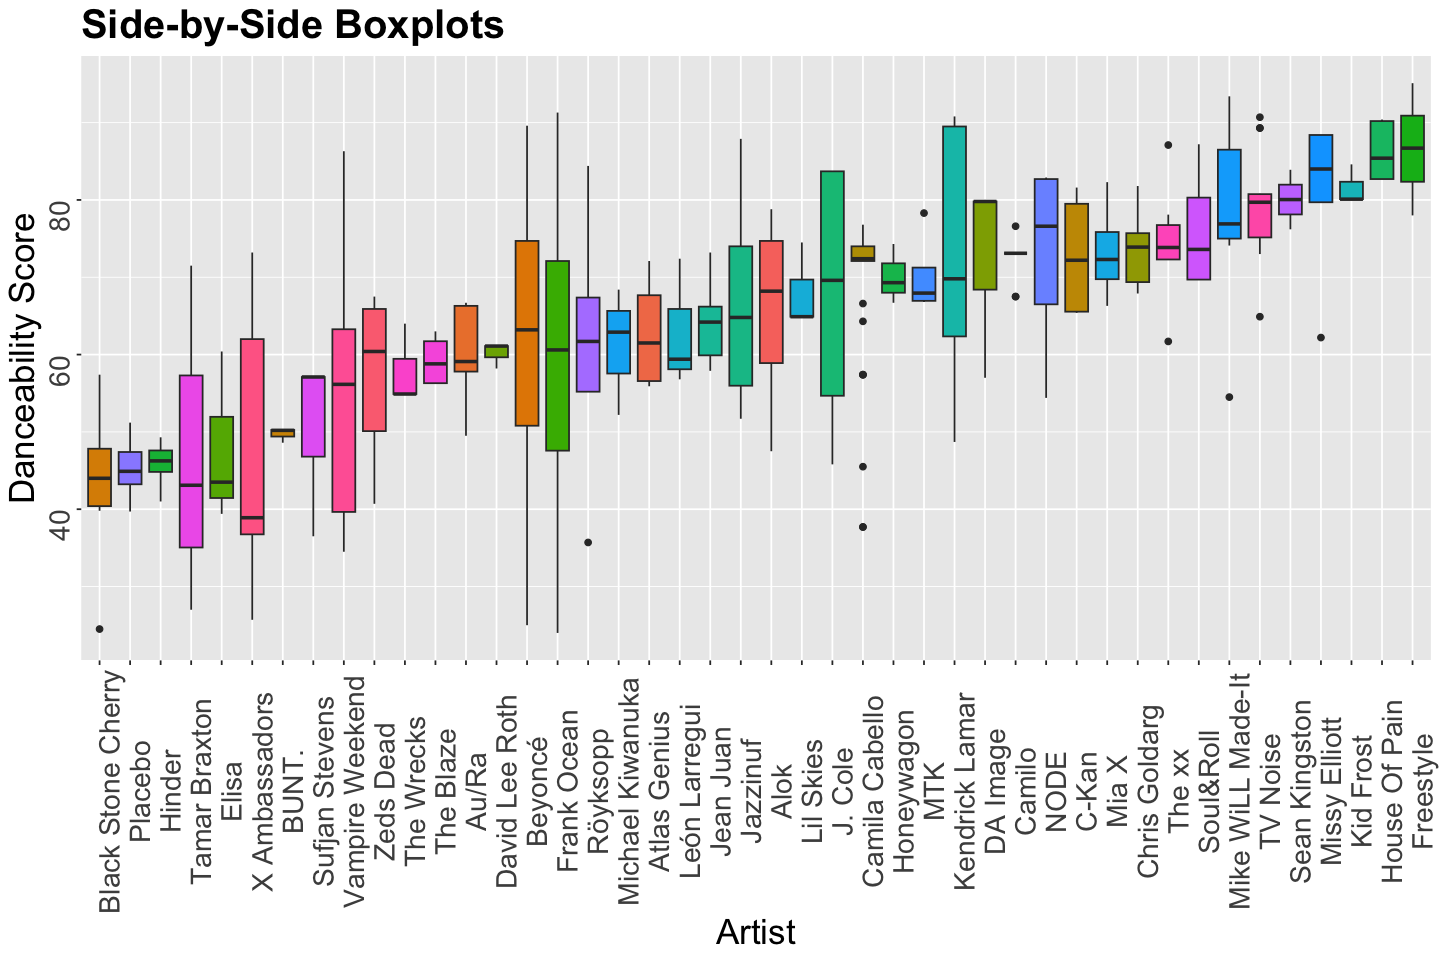

In [5]:
danceability_boxplots

The EDA gives us graphical insights into what artists are the most danceable. Nonetheless, **this is only a sample!** We need to set up a proper inferential model for our population of interest. 

Moreover, **keep in mind the variability from artist to artist**. Our Bayesian model needs to take this matter into account.

## 2. The Bayesian Hierarchical Model

According to our main statistical inquiries, let us start with hierarchical modelling.

### 2.1. The Likelihood

Let $Y_{i,j}$ be `danceability` score for the $i$th song in `spotify_training` (i.e., a row $i = 1, \dots, 350$) for the $j$th artist (a level in `artist` $j = 1, \dots, 44$). We will use a **Normal** likelihood:

$$Y_{i,j} \mid \mu_j, \sigma_w \sim \mathcal{N}(\mu_j, \sigma^2_w);$$

where $\mu_j$ is the mean `danceability` score for the $j$th artist and $\sigma_w$ is the standard deviation representing the **within-artist variability IN GENERAL**. Their **observations** correspond to **songs**.

```{exercise}
:label: lecture8-q1

Since `danceability` is bounded between 0 and 100, what other ideal distribution can we use aside from an unbounded Normal likelihood?

**A.** A Negative Binomial distribution.

**B.** A Gamma distribution.

**C.** A Beta distribution.

**D.** A Poisson distribution.
```

```{admonition} How can we set up the overall mean $\mu$?
:class: hint
This can be done by decomposing the mean $\mu_j$ for the $j$th artist as follows:

$$\mu_j = \mu + b_j;$$

where $\mu$ is the **overall mean** `danceability` for all the songs in the platform **(i.e., our first inquiry!)**, and $b_j$ is the mean `danceability` deviation of the $j$th artist **to the overall mean $\mu$** **(i.e., our second inquiry!)**. Note we will have 44 different $b_j$s since we have 44 artists. Furthermore, these deviations can be **either positive or negative**.
```

So far we have these `parameters` of interest:

- Overall mean `danceability` $\mu$.
- 44 mean `danceability` devations $b_j$.
- Within-group (i.e., within artist) variability via the standard deviation $\sigma_w$.

### 2.2. The Priors

Now, let us set the priors as a hierarchical model. For our 44 deviations $b_j$, we will have:

$$b_j \mid \sigma_\mu \sim \mathcal{N}(0, \sigma_\mu^2);$$

we assume a mean zero since we do not know whether the $j$th artist `danceability` will differ in average from the overall mean `danceability` $\mu$.  

Note we have another **parameter of interest**: the **between-artist variability** represented by the standard deviation $\sigma_\mu$. Therefore, we are basically decomposing the variance for the $i$th song and $j$th artist as:

$$\text{Var}\big(Y_{i,j}\big) = \sigma_\mu^2 + \sigma^2_w.$$ 

**Here comes the hierarchical twist...**

The **between-artist variability** represented by the standard deviation $\sigma_\mu$ will also have a prior. We are doing this to make our model flexible enough to apply the **"borrowing strength"** idea. Hence, the prior will be an Exponential distribution (non-negative continuous) since $\sigma_\mu$ is a standard deviation:

$$\sigma_\mu \sim \text{Exponential}(0.048),$$

which assigns higher probabilities to large values (i.e, **we believe there is a huge variability in `danceability` between artists in our prior**).

Finally, we need to set up priors for the overall mean `danceability` $\mu$ and within-artist variability via the standard deviation $\sigma_w$:

$$\mu \sim \mathcal{N}(50, 52^2)$$
$$\sigma_w \sim \text{Exponential}(1).$$

The prior for the **overall mean** `danceability` $\mu$ assigns a middle ground with high variability, while $\sigma_w$ has a prior assigning higher probabilities to values between 0 and 2. (compared to the prior of $\sigma_{\mu}$). **This prior belief denotes a moderate variability in danceability in the artist's catalogue.**

In [6]:
prior_normal_50_52 <- ggplot() +
  xlim(-200, 300) +
  ylim(0, 0.01) +
  geom_function(fun = dnorm, args = list(mean = 50, sd = 52), linewidth = 2) +
  theme(
    plot.title = element_text(size = 24),
    axis.text.x = element_text(size = 17, angle = 0),
    axis.text.y = element_text(size = 17, angle = 0),
    axis.title = element_text(size = 21),
  ) +
  labs(y = "Density", x = expression(mu)) +
  ggtitle(expression(paste("Prior Normal(50, ", 52^2, ")")))

prior_exp_0.048 <- ggplot() +
  xlim(0, 140) +
  ylim(0, 0.05) +
  geom_function(fun = dexp, args = list(rate = 0.048), linewidth = 2) +
  theme(
    plot.title = element_text(size = 24),
    axis.text.x = element_text(size = 17, angle = 0),
    axis.text.y = element_text(size = 17, angle = 0),
    axis.title = element_text(size = 21),
  ) +
  labs(y = "Density", x = expression(sigma[mu])) +
  ggtitle(expression("Prior Exponential(0.048)"))

prior_exp_1 <- ggplot() +
  xlim(0, 5) +
  ylim(0, 1) +
  geom_function(fun = dexp, args = list(rate = 1), linewidth = 2) +
  theme(
    plot.title = element_text(size = 24),
    axis.text.x = element_text(size = 17, angle = 0),
    axis.text.y = element_text(size = 17, angle = 0),
    axis.title = element_text(size = 21),
  ) +
  labs(y = "Density", x = expression(sigma["w"])) +
  ggtitle(expression("Prior Exponential(1)"))

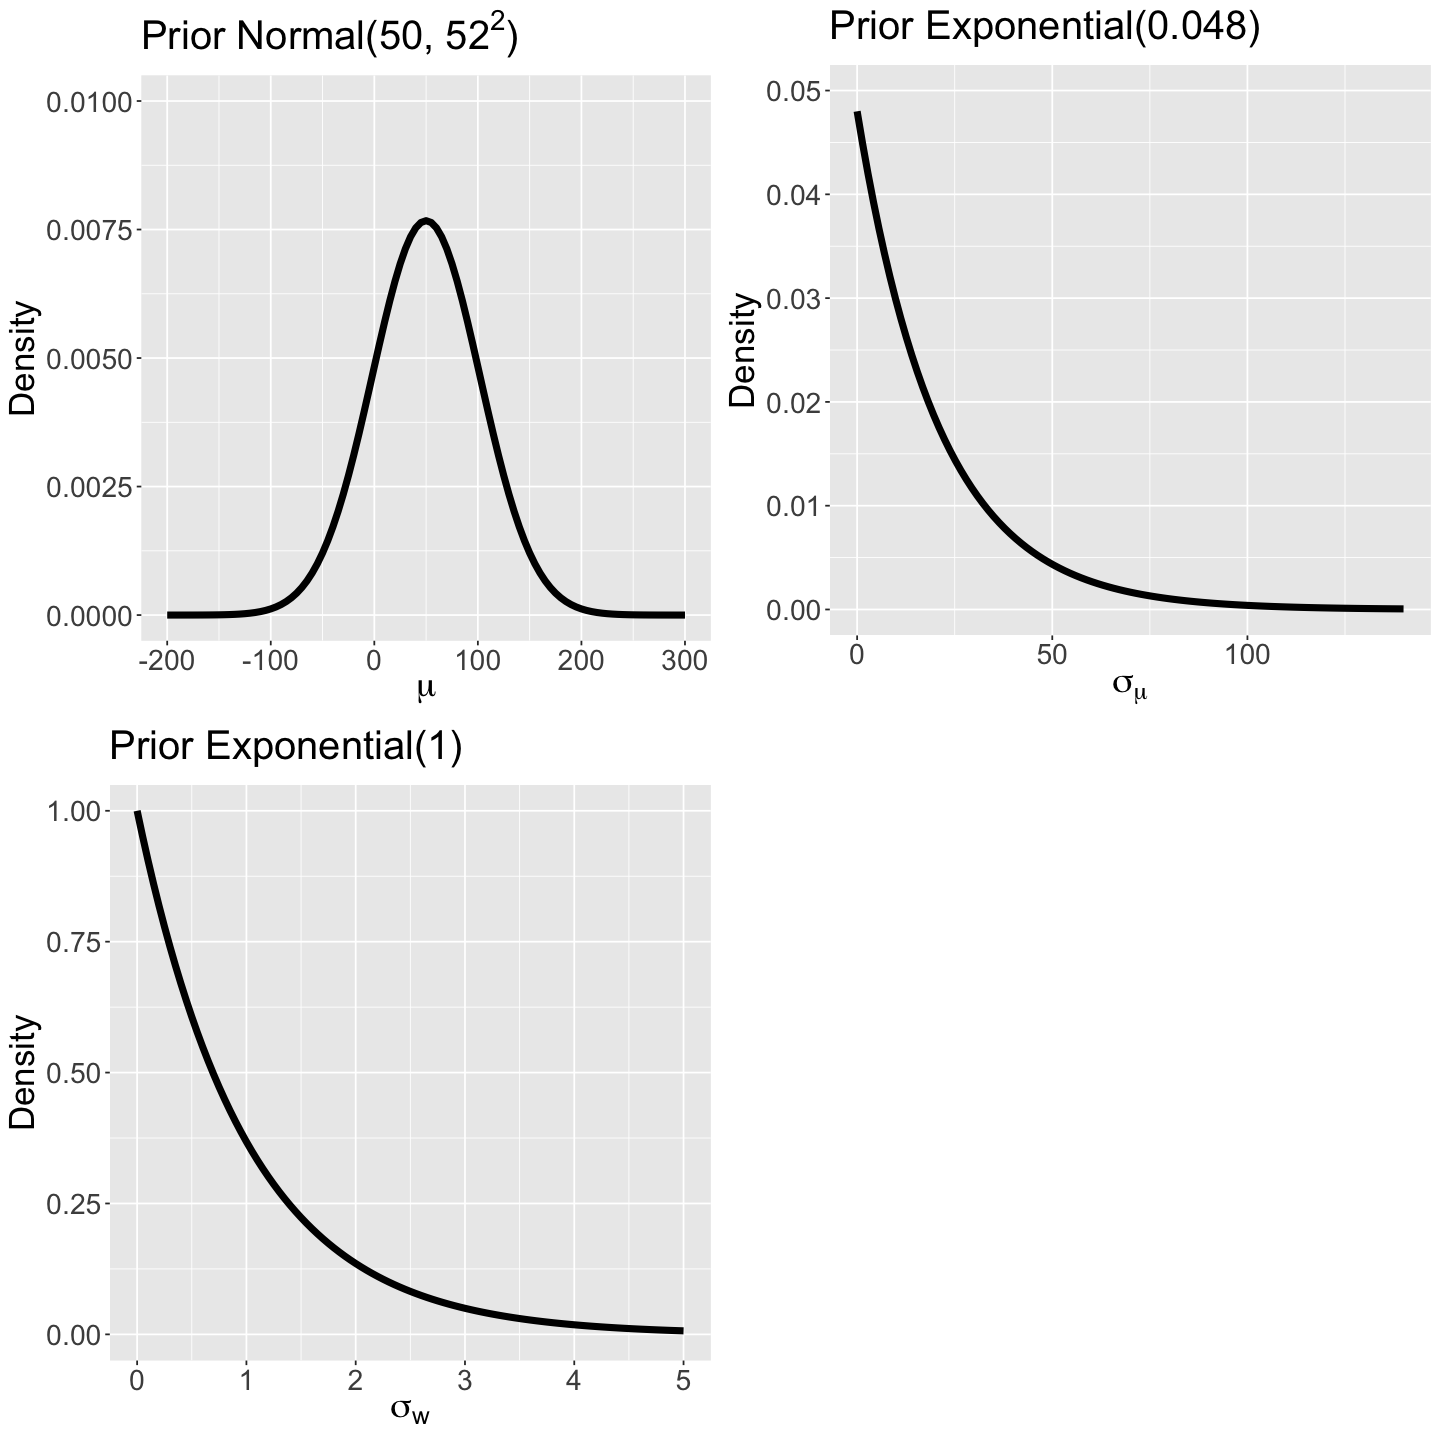

In [7]:
options(repr.plot.height = 12, repr.plot.width = 12)

plot_grid(prior_normal_50_52, prior_exp_0.048, prior_exp_1)

The formal Bayesian hierarchical model is set up as:

```{math}
\begin{align*}
\text{likelihood:} \qquad Y_{i,j} \mid \mu_j, \sigma_w \sim \mathcal{N}(\mu_j, \sigma^2_w) \\ 
\text{where} \quad \mu_j = \mu + b_j \\
\text{priors:} \quad b_j \mid \sigma_\mu \sim \mathcal{N}(0, \sigma_\mu^2) \\
\qquad \mu \sim \mathcal{N}(50, 52^2) \\
\qquad \sigma_w \sim \text{Exponential}(1) \\
\qquad \sigma_\mu \sim \text{Exponential}(0.048).
\end{align*}
```

```{exercise}
:label: lecture8-q2

What other prior distribution can we use for both types of variance?

**A.** A Gamma distribution.

**B.** A Binomial distribution.

**C.** A Poisson distribution.

**D.** A Chi-squared distribution.
```

### 2.3. Coding the Model

We code up this `spotify_model` model on `Stan`. The structure is similar to the baseball case from `lab2`.

In [8]:
spotify_model <- "data {                          
int<lower=1> n;                     //rows in training set
int<lower=1> num_artist;            //number of artists in training set
int<lower=1> artist[n];             //artist ID column by song in training set
vector[n] dance_score;              //danceability scores by song in training set             
}
parameters {
vector[num_artist] mean_dance;      //vector of posterior danceability score deviations for each artist (size num_artist)
real overall_mean;                  //overall mean in danceability score
real<lower=0> between_sigma;        //between-artist sd in danceability score
real<lower=0> within_sigma;         //within-artist sd in danceability score
}
model {
between_sigma ~ exponential(0.048);     //between-artist sd prior
within_sigma ~ exponential(1);  //within-artist sd prior
overall_mean ~ normal(50, 52);      //overall mean prior
for (j in 1:num_artist){            //danceability scores priors (deviations per artist)
  mean_dance[j] ~ normal(0, between_sigma);
}
for (i in 1:n){
  int artist_index = artist[i];     //auxiliary indexing variable
  dance_score[i] ~ normal(overall_mean + mean_dance[artist_index], within_sigma); //likelihood in training set
}
}"

### 2.4. Running the MCMC Simulation

Before creating the `spotify_dictionary`, we switch the ID names to numerical codes from `1` to `44` according to the alphabetical order in the levels of `spotify_training$artist`. We need to do this since we cannot work with factor levels in `Stan`. Then, we run the simulation.

In [9]:
levels(spotify_training$artist) <- 1:44

spotify_dictionary <- list(
  n = nrow(spotify_training),
  num_artist = nrow(artist_catalogue),
  artist = as.integer(spotify_training$artist),
  dance_score = spotify_training$danceability
)

posterior_spotify <- stan(
  model_code = spotify_model,
  data = spotify_dictionary,
  chains = 1,
  iter = 20000,
  warmup = 2000,
  thin = 20,
  seed = 553
)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 5.9e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:     1 / 20000 [  0%]  (Warmup)
Chain 1: Iteration:  2000 / 20000 [ 10%]  (Warmup)
Chain 1: Iteration:  2001 / 20000 [ 10%]  (Sampling)
Chain 1: Iteration:  4000 / 20000 [ 20%]  (Sampling)
Chain 1: Iteration:  6000 / 20000 [ 30%]  (Sampling)
Chain 1: Iteration:  8000 / 20000 [ 40%]  (Sampling)
Chain 1: Iteration: 10000 / 20000 [ 50%]  (Sampling)
Chain 1: Iteration: 12000 / 20000 [ 60%]  (Sampling)
Chain 1: Iteration: 14000 / 20000 [ 70%]  (Sampling)
Chain 1: Iteration: 16000 / 20000 [ 80%]  (Sampling)
Chain 1: Iteration: 18000 / 20000 [ 90%]  (Sampling)
Chain 1: Iteration: 20000 / 20000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 1.409 seconds (Warm-up)
Chain 1:                6.71 seconds (Samplin

### 2.5. Output Summary 

We obtain the output from `posterior_spotify`. Firstly, let us focus the attention on the overall `danceability` $\mu$ (`overall_mean`), the between-artist standard deviation $\sigma_\mu$ (`between_sigma`), and within-artist standard deviation $\sigma_w$ (`within_sigma`).

In [10]:
summary_overall <- as.data.frame(summary(posterior_spotify)$summary)
summary_overall <- summary_overall[45:47, c("mean", "sd", "2.5%", "97.5%")] |>
  mutate_if(is.numeric, round, 3)
summary_overall

,mean,sd,2.5%,97.5%
,<dbl>,<dbl>,<dbl>,<dbl>
overall_mean,65.228,1.751,61.744,68.579
between_sigma,10.128,1.504,7.588,13.373
within_sigma,12.013,0.476,11.126,12.984


**For our first inquiry**, we can conclude the following:

- The overall `danceability` $\mu$ is between 61.744 and 68.579 with 95% probability and a posterior mean of 65.228. 
- Moreover, we see more variability associated with the between-artist standard deviation $\sigma_\mu$ which makes sense (artist diversity should be large in the platform!). Note the 95% credible interval between 7.588 and 13.373.
- On the other hand, the within-artist variability $\sigma_w$ shows less variability. Note the 95% credible interval between 11.126 and 12.984.

In [11]:
options(repr.plot.height = 10, repr.plot.width = 12)

post_hist_spotify <- mcmc_areas(posterior_spotify, pars = c(
  "overall_mean",
  "between_sigma",
  "within_sigma"
)) +
  theme(
    plot.title = element_text(size = 16.5, face = "bold", family = "sans"),
    axis.text.x = element_text(size = 16.5, angle = 0, family = "sans"),
    axis.text.y = element_text(size = 16.5, angle = 0, family = "sans"),
    axis.title = element_text(size = 16.5, family = "sans"),
    strip.text.x = element_text(size = 16.5, family = "sans")
  ) +
  ggtitle("Posterior Distribution and 95% Credible Intervals of Overall Mean and Standard Deviations") +
  scale_x_continuous(breaks = seq(0, 70, 5)) +
  xlab("Danceability")

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


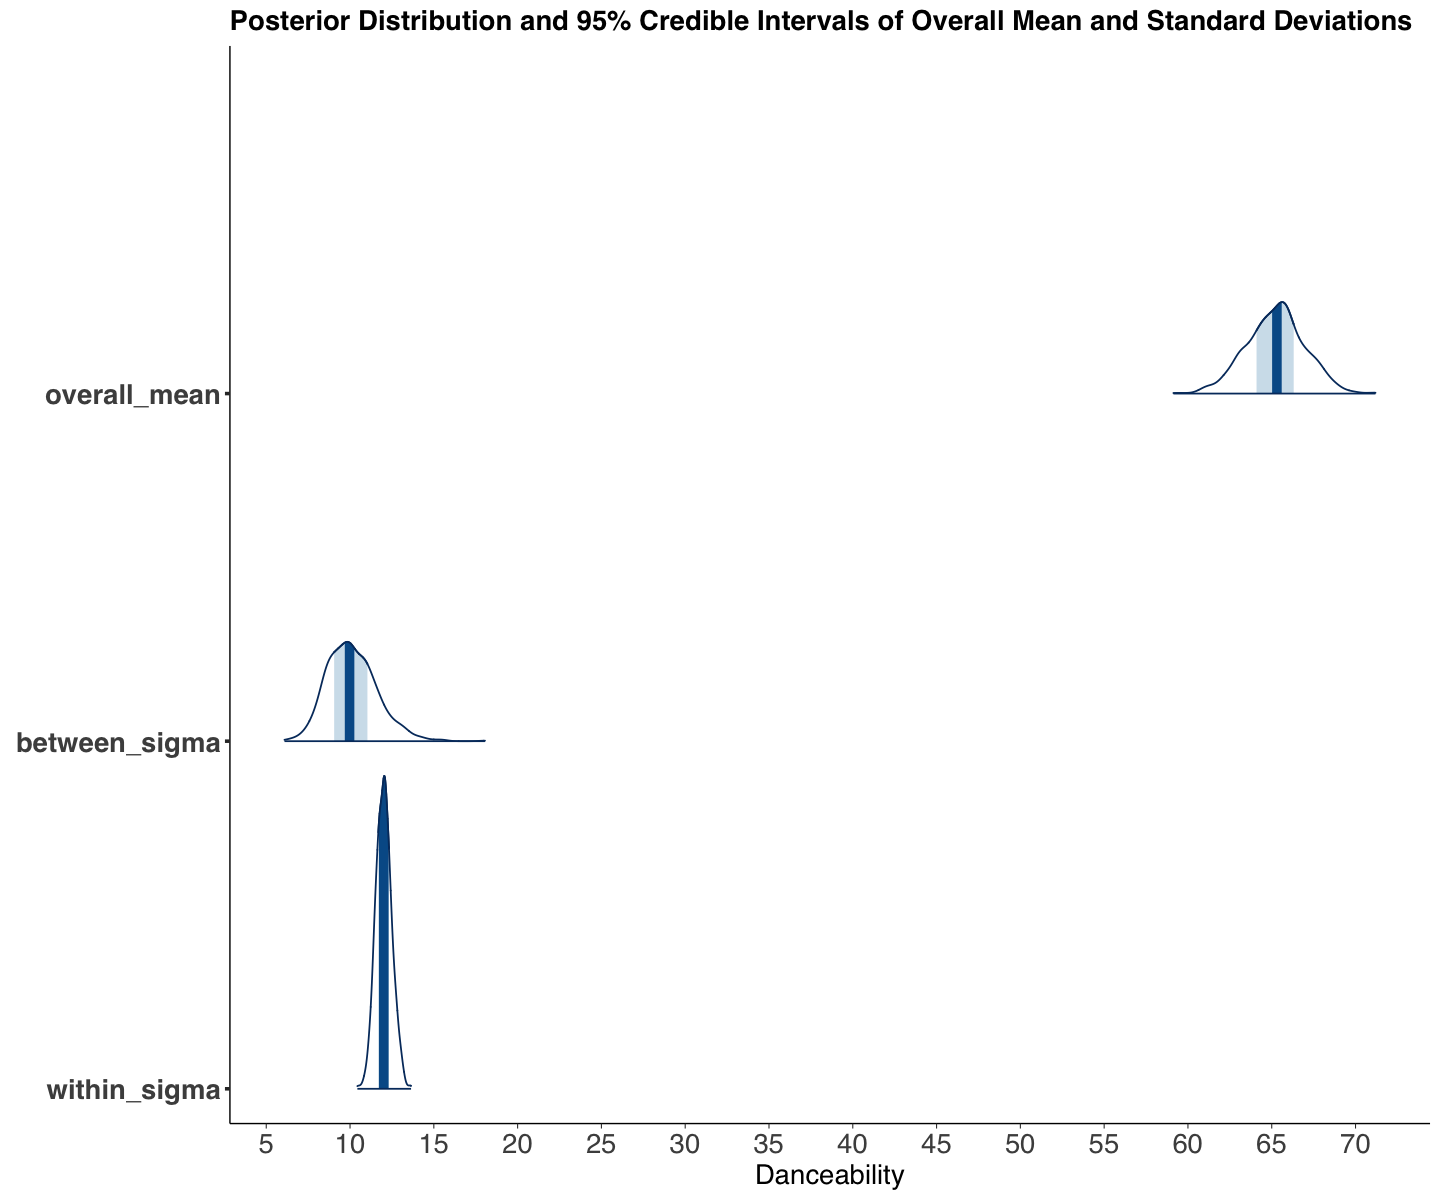

In [12]:
post_hist_spotify

**What about the mean `danceability` deviations by artist $b_j$?**

Recall these deviations could be positive or negative given how we modelled them:

$$\mu_j = \mu + b_j.$$

Since `Stan` labels the parameters in the posterior samples as `mean_dance[1]`, ..., `mean_dance[44]`, we will add a new column with the actual `artist` name stored in `artist_catalogue`.

In [13]:
summary_artist_means <- as.data.frame(summary(posterior_spotify)$summary)
summary_artist_means <- summary_artist_means[1:44, c("mean", "sd", "2.5%", "97.5%")] |>
  mutate_if(is.numeric, round, 3)
summary_artist_means$artist <- as.factor(artist_catalogue$artist)
summary_artist_means |>
  arrange(-mean) 

,mean,sd,2.5%,97.5%,artist
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
mean_dance[18],16.324,5.072,6.793,26.317,House Of Pain
mean_dance[15],14.339,5.997,3.167,27.308,Freestyle
mean_dance[41],12.673,3.437,5.771,19.364,TV Noise
mean_dance[29],11.903,4.897,2.387,21.454,Missy Elliott
⋮,⋮,⋮,⋮,⋮,⋮
mean_dance[43],-14.321,4.350,-22.955,-6.364,X Ambassadors
mean_dance[16],-15.724,4.758,-25.361,-6.106,Hinder
mean_dance[32],-16.089,4.691,-25.402,-7.092,Placebo
mean_dance[5],-17.585,4.517,-26.706,-9.478,Black Stone Cherry


Recall our **second inquiry**:

> Assuming the `spotify` dataset is representative enough of the 44 artists discography, how danceable is their music compared to the overall **mean danceability** for the songs on the platform?

Let us focus on the top 10 posterior means for deviation $b_j$ (they are plotted below along with their 95% credible intervals). Four artists have their credible intervals with positive bounds (i.e., there is a 95% probability they are more danceable than the overall `danceability` mean $\mu$!): `House of Pain`, `Freestyle`, `TV Noise`, and `Missy Elliot`.

In [14]:
posterior_artist_means_CIs_plot <- summary_artist_means |>
  arrange(-mean) |>
  slice(1:10) |>
  mutate(artist = fct_reorder(artist, mean)) |>
  ggplot(aes(x = mean, y = artist)) +
  geom_errorbarh(aes(xmax = `2.5%`, xmin = `97.5%`, color = artist)) +
  geom_point(color = "blue") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    legend.position = "none"
  ) +
  ggtitle("95% CIs for Artist Mean Deviations") +
  labs(x = "Artist Mean Deviation", y = "Artist") +
  geom_vline(xintercept = 0, linetype = "dashed")

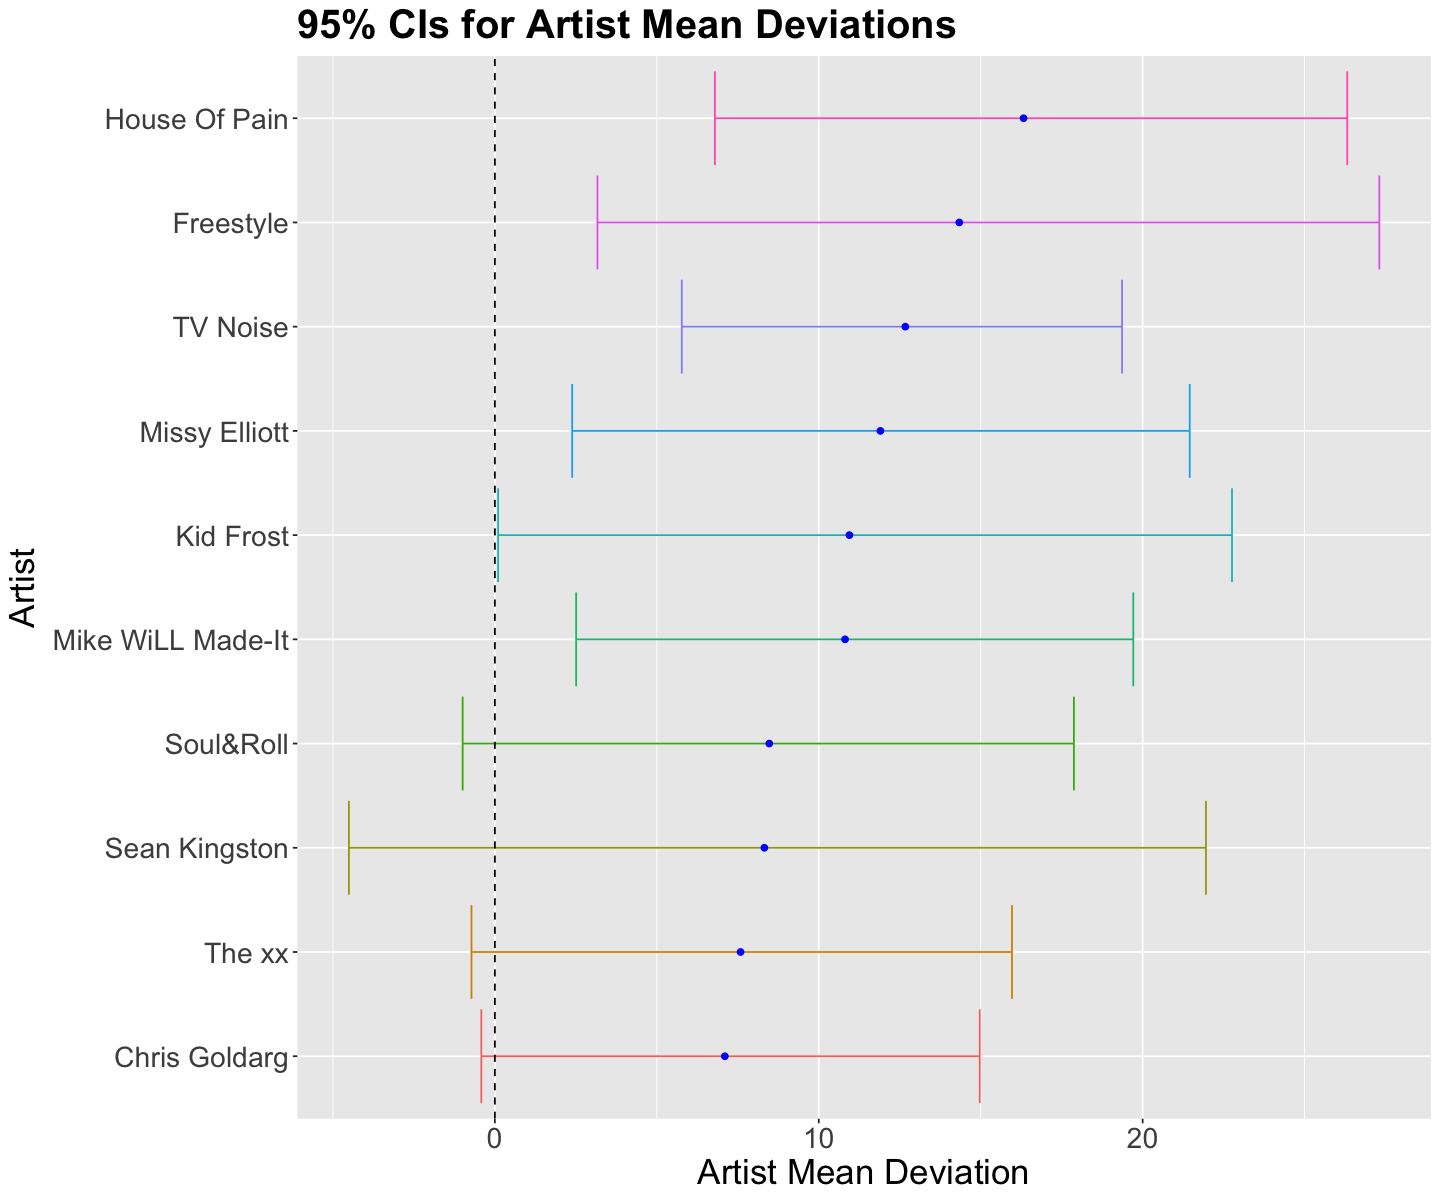

In [15]:
posterior_artist_means_CIs_plot

Even though the hierarchical model can reduce the variability in our posterior estimates, we need to help it by including features! Since

$$\mu_j = \mu + b_j,$$

we might break down the mean deviation $b_j$ with a regression systematic component. **This is a potential improvement for this model!**

## 3. MCMC Diagnostics

This is the last topic of the block, and it will allow evaluating the MCMC posterior sampling quality.

There are many potential pitfalls in MCMC: **not enough iterations**, **not enough thinning**, **not enough burn-in**, etc. So how do we know if it worked and is giving us "good" samples from the approximate posterior distribution? Thankfully, there are MCMC convergence diagnostics to provide us with a sense of whether we can trust the output of our MCMC algorithm.

We are sampling via a Markov chain; thus, our sampled elements (i.e., "links" in the chain) will not be fully independent. However, we can make them "semi-independent" with the `thin` argument. Nonetheless, each Bayesian case behaves differently, and some are harder than others. Therefore, thinning can sometimes be less effective.

Furthermore, a common practice is to sample via more than one chain. We would expect sampling consistency across all chains.

```{warning}
Sampling consistency across chains does not necessarily implicate the algorithm walks are quickly converging in all chains. That said, all sampling chains could also be equally bad!
```

To illustrate the use of MCMC diagnostics, let us sample four chains for the previous Spotify case. We will have the following number of posterior samples by chain: 

$$\texttt{samples} = \frac{\texttt{iterations} - \texttt{warmup}}{\texttt{thin}} = \frac{20,000 - 2,000}{20} = 900.$$

In [16]:
posterior_spotify_4_chains <- stan(
  model_code = spotify_model,
  data = spotify_dictionary,
  chains = 4,
  iter = 20000,
  warmup = 2000,
  thin = 20,
  seed = 553
)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.3e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:     1 / 20000 [  0%]  (Warmup)
Chain 1: Iteration:  2000 / 20000 [ 10%]  (Warmup)
Chain 1: Iteration:  2001 / 20000 [ 10%]  (Sampling)
Chain 1: Iteration:  4000 / 20000 [ 20%]  (Sampling)
Chain 1: Iteration:  6000 / 20000 [ 30%]  (Sampling)
Chain 1: Iteration:  8000 / 20000 [ 40%]  (Sampling)
Chain 1: Iteration: 10000 / 20000 [ 50%]  (Sampling)
Chain 1: Iteration: 12000 / 20000 [ 60%]  (Sampling)
Chain 1: Iteration: 14000 / 20000 [ 70%]  (Sampling)
Chain 1: Iteration: 16000 / 20000 [ 80%]  (Sampling)
Chain 1: Iteration: 18000 / 20000 [ 90%]  (Sampling)
Chain 1: Iteration: 20000 / 20000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 1.294 seconds (Warm-up)
Chain 1:                5.628 seconds (Sampli

### 3.1. Trace Plots

Trace plots horizontally illustrate the posterior sampling by a chain. All chain evolutions (**excluding warmup**) are overlaid. We will have a trace plot by a parameter of interest (here, we are only plotting `overall_mean`, `between_sigma`, and `within_sigma` for practical purposes).

Ideally, **there should be a flat pattern by parameter without any upward or a downward trend throughout the chain**. Moreover, **we should not see any chain stuck**. The function `mcmc_trace()` from `bayesplot` automatically displays these plots.

In [17]:
color_scheme_set("mix-blue-pink")

trace_spotify_4_chains <- mcmc_trace(posterior_spotify_4_chains,
  pars = c(
    "overall_mean",
    "between_sigma",
    "within_sigma"
  ),
  size = 0.1,
  facet_args = list(nrow = 3)
) +
  ggtitle("Trace Plots by Parameter of Interest") +
  theme(
    plot.title = element_text(size = 24, face = "bold", family = "sans"),
    axis.text = element_text(size = 17, family = "sans"),
    axis.title = element_text(size = 21, family = "sans"),
    legend.text = element_text(size = 17, family = "sans"),
    legend.title = element_text(size = 17, family = "sans")
  ) +
  facet_text(size = 26)

In the Spotify case (for `overall_mean`, `between_sigma`, and `within_sigma`), we see acceptable proper plots (flat horizontal trends and no chain stucks).

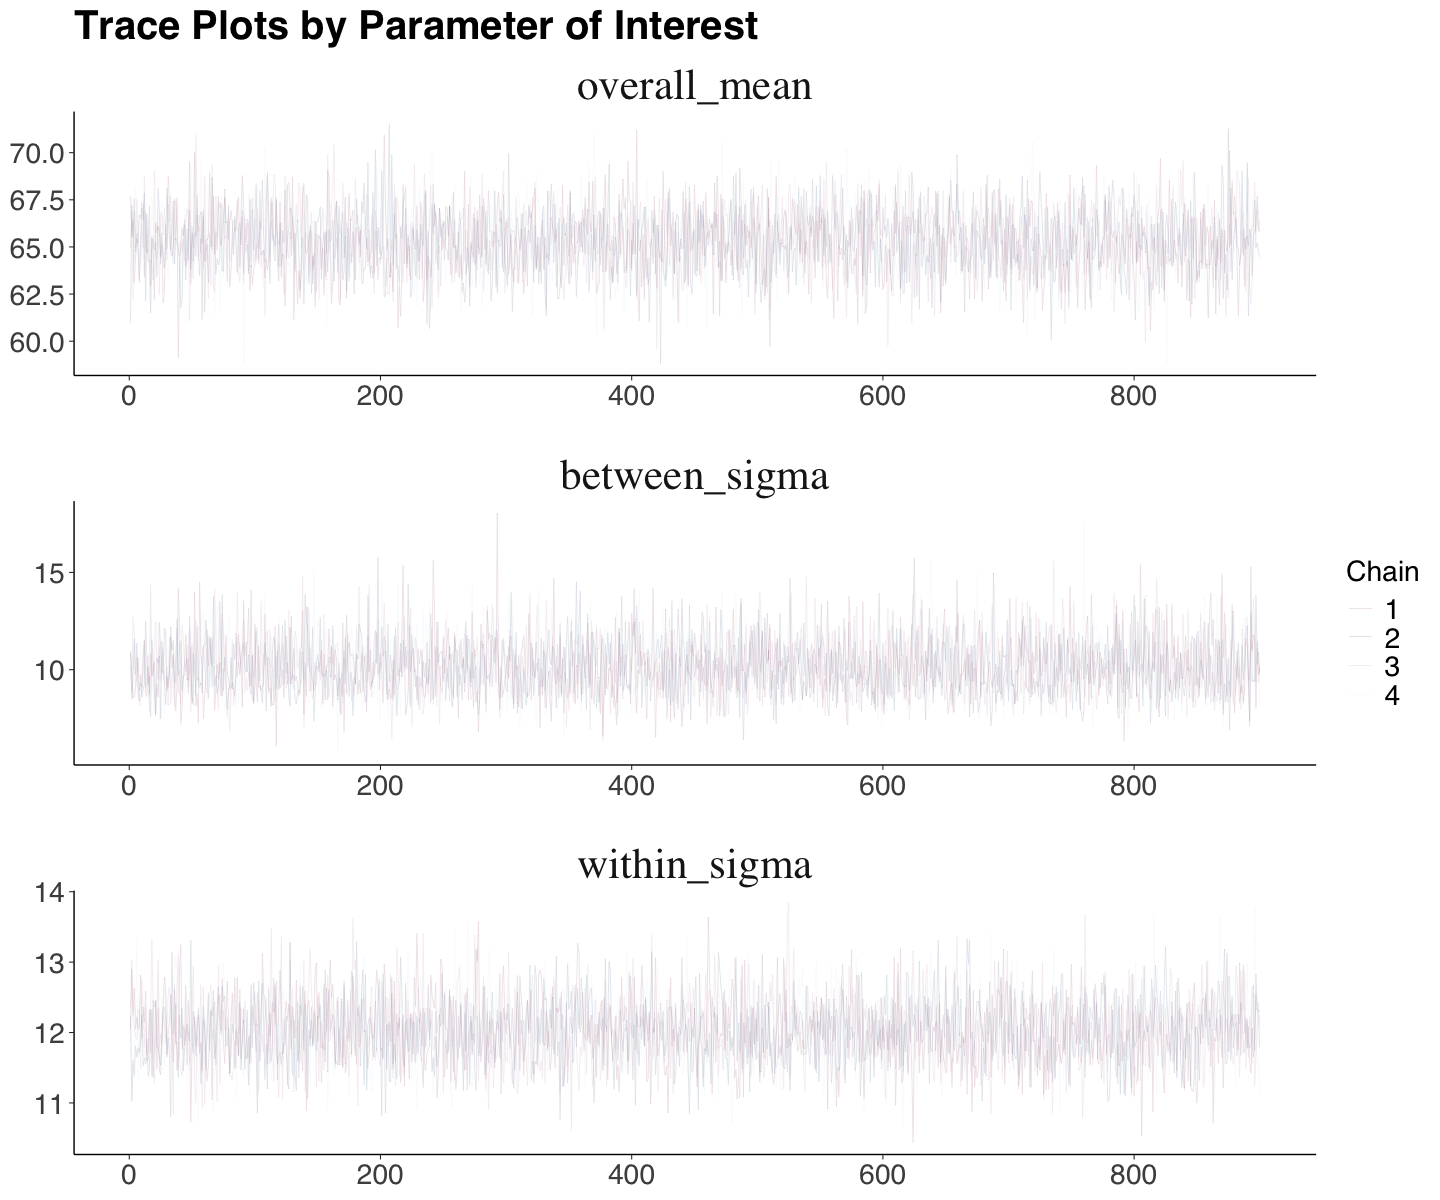

In [18]:
trace_spotify_4_chains

The cases below belong to other toy examples (Beta-Binomial models) with bad MCMC samplings. Note **the downward trend in Chain A** and **the sampling stuck in Chain B**. The downward trend implicates the algorithm is sampling smaller parameter values throughout the simulation.

<br>
<center><img width="1000" src="https://www.bayesrulesbook.com/bookdown_files/figure-html/bad-trace-1.png"/></center>

*Source: [Johnson et al. (2021)](https://www.bayesrulesbook.com/chapter-6.html#diagnostics)*

### 3.2. Empirical Density Plots

We can also obtain empirical density plots for the parameters of interest with our MCMC posterior samples. The function `mcmc_dens_overlay()` from `bayesplot` automatically displays these overlaid plots (one by chain and parameter). Ideally, **the overlaid plots would show similar behaviours to conclude chain consistency.**

In [19]:
density_spotify_4_chains <- mcmc_dens_overlay(posterior_spotify_4_chains,
  pars = c(
    "overall_mean",
    "between_sigma",
    "within_sigma"),
  facet_args = list(nrow = 3)) +
  ggtitle("Overlaid Density Plots by Parameter of Interest") +
  theme(
    plot.title = element_text(size = 24, face = "bold", family = "sans"),
    axis.text = element_text(size = 17, family = "sans"),
    axis.title = element_text(size = 21, family = "sans"),
    legend.text = element_text(size = 17, family = "sans"),
    legend.title = element_text(size = 17, family = "sans")
  ) +
  facet_text(size = 26)

We see the same overall pattern with minor local variations in the Spotify case (for `overall_mean`, `between_sigma`, and `within_sigma`).

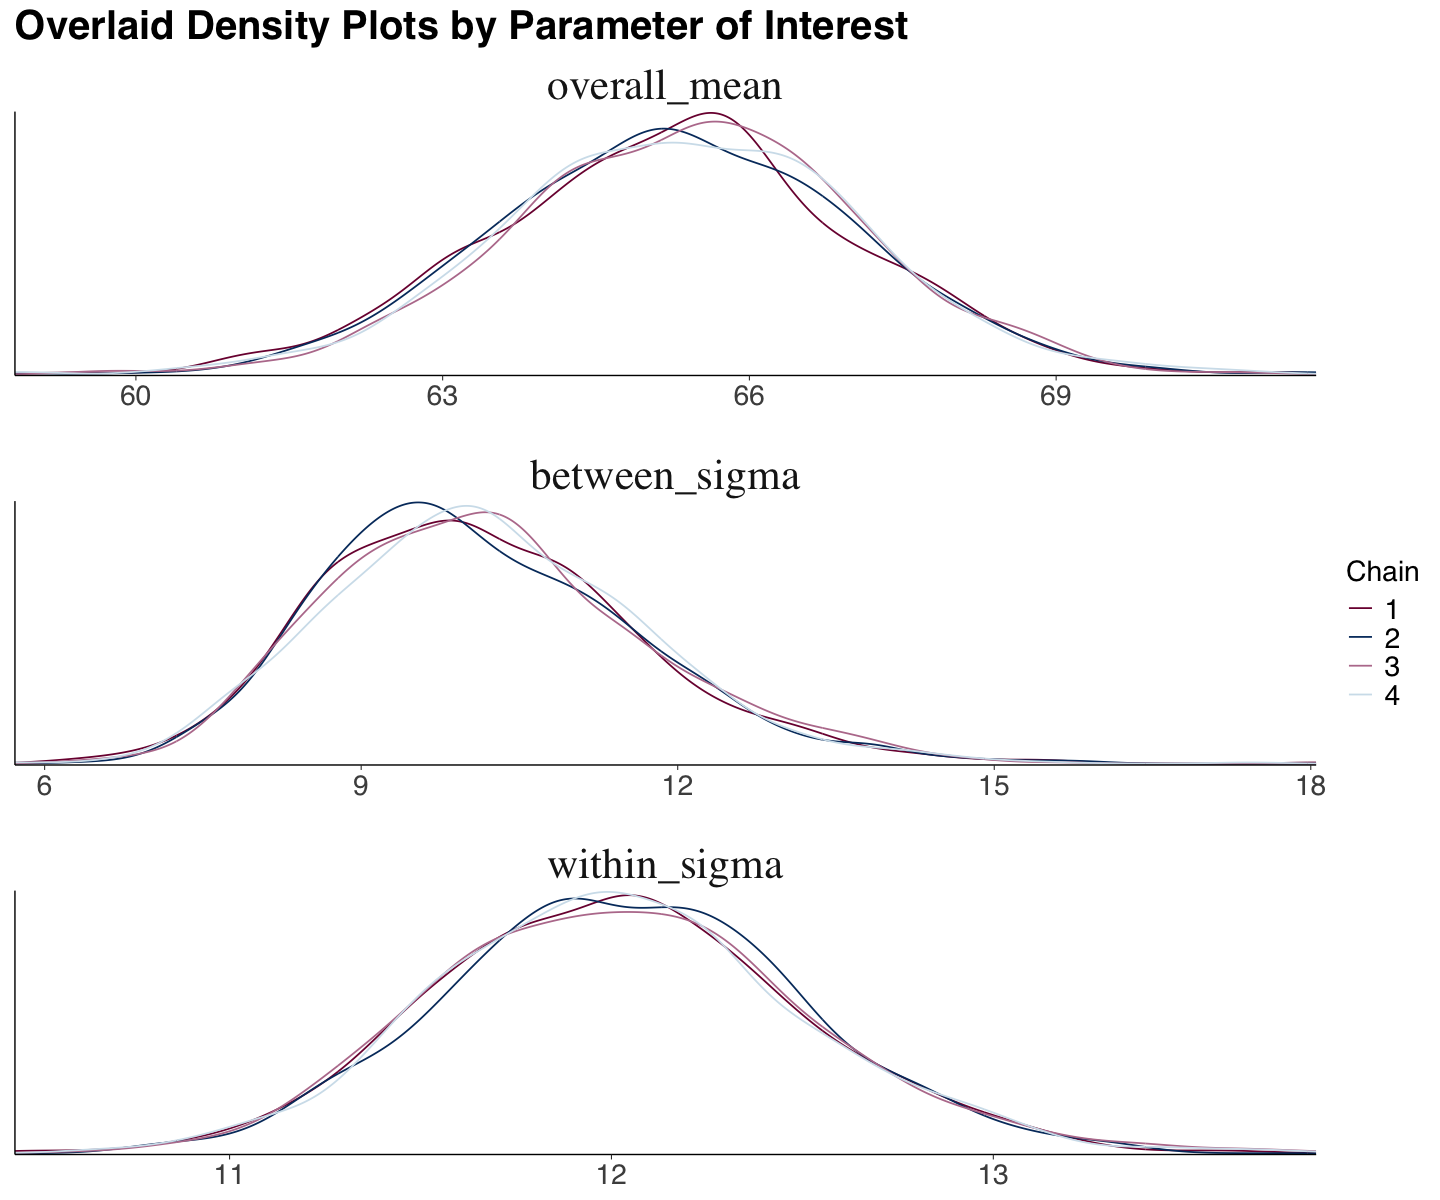

In [20]:
density_spotify_4_chains

### 3.3. Effective Sample Size

The effective sample size $N_{\text{eff}}$ is a metric that measures the number of **independent** samples it would take to achieve an accurate MCMC posterior approximation. 

If $N$ is the length of a given chain, given the characteristics of MCMC, **we would expect that $N_{\text{eff}} < N$**. **Ideally**, $N_{\text{eff}}$ should be as close as possible to $N$ or their correspoding ratio close to 1:

$$\frac{N_{\text{eff}}}{N}.$$

```{important}
**Ideally**, the above ratio should be as close as $1$ since $N_{\text{eff}}$ represents the number of **fully independent** posterior samples we would need to get an accurate posterior approximation (such as in a Monte Carlo simulation!). On the other hand, in practice, given its link structure and our warmup and thinning settings, MCMC would need more than $N_{\text{eff}}$ to achieve an accurate posterior approximation (i.e., $N > N_{\text{eff}}$). Nevertheless, it might be the case (as in this example) that this ratio can be larger than $1$ **for standalone parameters**.

Having said that, note we could have the following possible scenarios:

- **For a given standalone parameter**, a ratio $\frac{N_{\text{eff}}}{N} < 1$ indicates that our MCMC sampling would need a larger number of samples $N$ to be as good as a Monte Carlo simulation. Again, recall we draw this conclusion **per standalone parameter**. Therefore, we would increase the number of iterations **AND/OR** thinning in the MCMC sampling **once we see a big picture across all our parameters of interest in the model**.
- **For a given standalone parameter**, a ratio $\frac{N_{\text{eff}}}{N} = 1$ indicates that our MCMC sampling is as good as a Monte Carlo simulation. Again, recall we can only draw this conclusion **per standalone parameter**. If all the parameters of interest show ratios $\frac{N_{\text{eff}}}{N}$ close enough to $1$ (either slightly above or below), we could leave the `sampling()` setup as is. On the other hand, some parameters in the model will show a ratio close to $1$, while others will not. Thus, we might need to **modify accordingly** the number of iterations **AND/OR** thinning **once we see a big picture across all our parameters of interest in the model**. 
- **For a given standalone parameter**, a ratio $\frac{N_{\text{eff}}}{N} > 1$ indicates that our MCMC sampling needs less posterior samples $N$ to be as good as a Monte Carlo simulation. Again, recall we can only draw this conclusion **per standalone parameter**. Possibly, some parameters will show a ratio $> 1$ while others will have a ratio quite close or equal to $1$ (or even have a ratio $< 1$!). Thus, we might need to **modify accordingly** the number of iterations **AND/OR** thinning **once we see a big picture across all our parameters of interest in the model**.
```

The ratios, by parameter of interest, can be obtained via `neff_ratio()` from `bayesplot`. The specific mathematical computation for $N_{\text{eff}}$ can be found [here](https://mc-stan.org/docs/reference-manual/effective-sample-size.html).

In [21]:
spotify_eff_sample_size <- neff_ratio(posterior_spotify_4_chains,
  pars = c(
    "overall_mean",
    "between_sigma",
    "within_sigma")
)
round(spotify_eff_sample_size, 3)

overall_mean between_sigma  within_sigma 
        1.001         1.079         0.965

Our effective sample sizes for `overall_mean`, `between_sigma`, and `within_sigma` indicate an **acceptable performance effective sample size** (all three are **around** $1$).

We can use `mcmc_neff()` if we want to plot these ratios. For the Spotify case, there are no major concerns regarding these metrics.

In [22]:
eff_sample_size_4_chains <- mcmc_neff(spotify_eff_sample_size, size = 2) +
  ggtitle("Effective Sample Sizes by Parameter of Interest") +
  theme(
    plot.title = element_text(size = 24, face = "bold", family = "sans"),
    axis.text = element_text(size = 17, family = "sans"),
    axis.title = element_text(size = 21, family = "sans"),
    legend.text = element_text(size = 17, family = "sans"),
    legend.title = element_text(size = 17, family = "sans")
  ) +
  facet_text(size = 26)

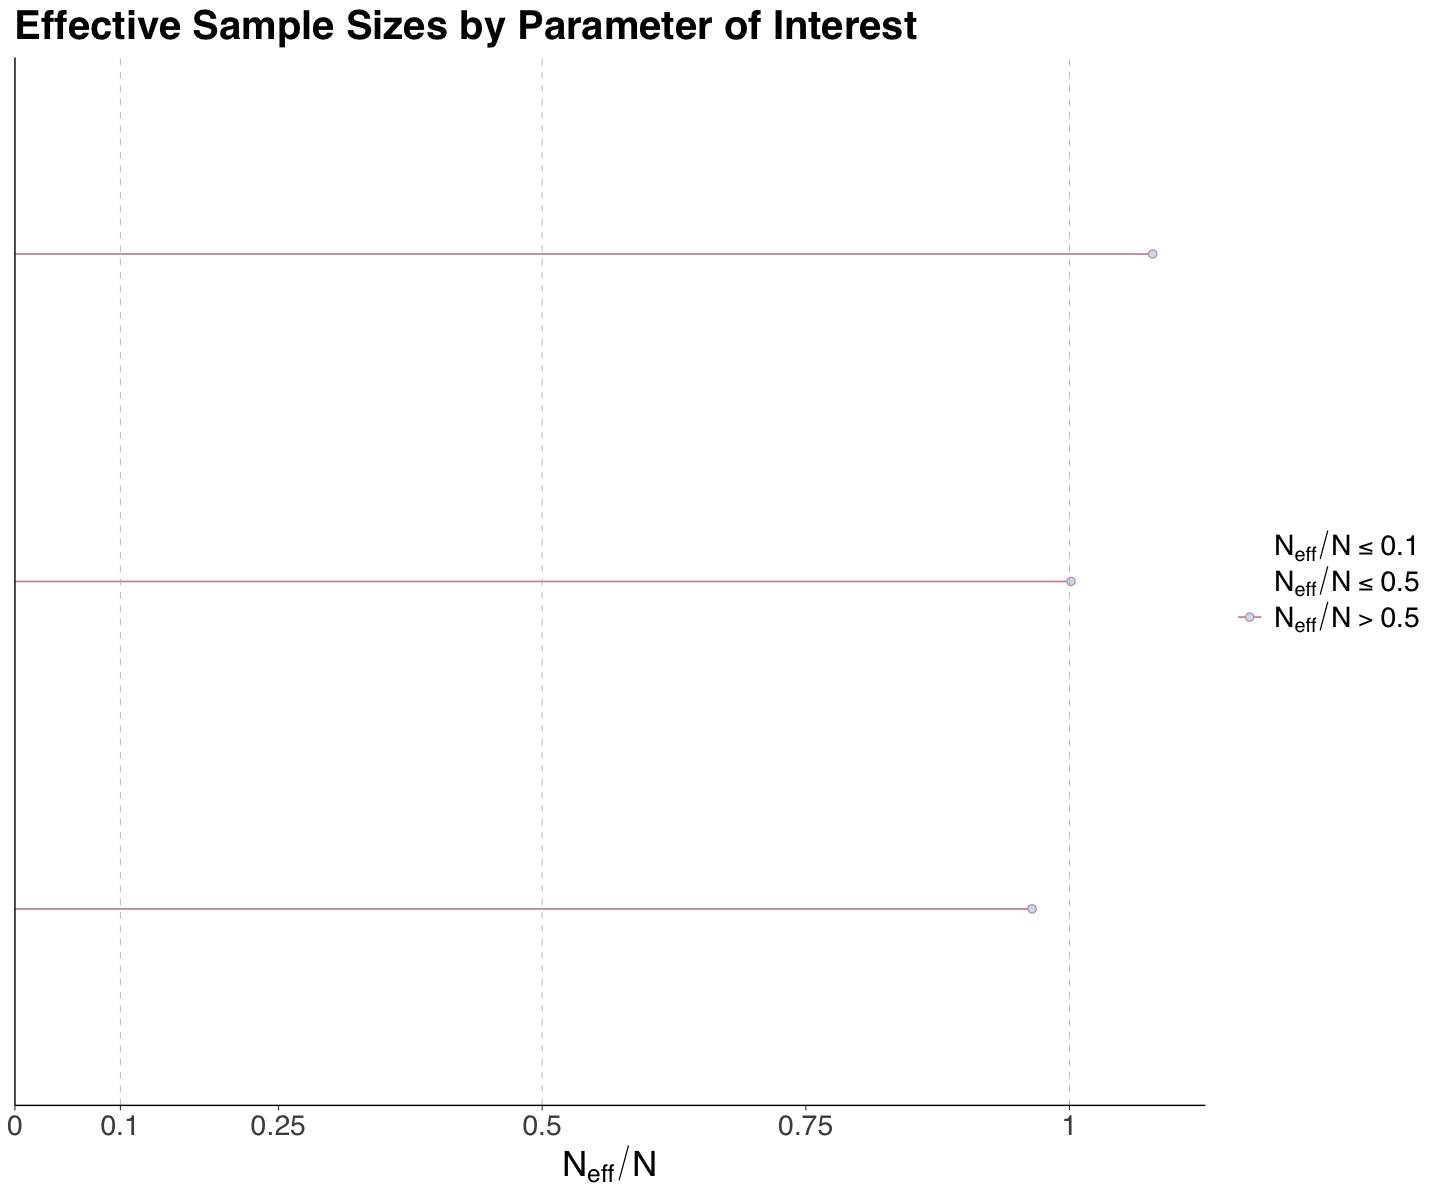

In [23]:
eff_sample_size_4_chains

### 3.4. Autocorrelation

Recall our MCMC posterior samples are not entirely independent. Therefore, **we need to measure autocorrelation across the posterior samples by parameter and chain**.

We can automatically display the correlation plot via `mcmc_acf()` from `bayesplot`. The $y$-axis indicates the autocorrelation function (`ACF`), **for which 0 indicates no autocorrelation and 1 indicates full autocorrelation**. The $x$-axis indicates the lag, i.e., how many steps apart the posterior samples are in the random walk.

In [24]:
lag_4_chains <- mcmc_acf(posterior_spotify_4_chains,
  pars = c(
    "overall_mean",
    "between_sigma",
    "within_sigma")
  ) +
  ggtitle("Autocorrelation Plots by Parameter of Interest") +
  theme(
    plot.title = element_text(size = 24, face = "bold", family = "sans"),
    axis.text = element_text(size = 17, family = "sans"),
    axis.title = element_text(size = 21, family = "sans"),
    legend.text = element_text(size = 17, family = "sans"),
    legend.title = element_text(size = 17, family = "sans")
  ) +
  facet_text(size = 26)

For the Spotify case, the autocorrelation significantly decreases before lag 5; this is a sign of a **quick mixing** (i.e., the chain is fast-moving around a well-defined parameter space of posterior values).

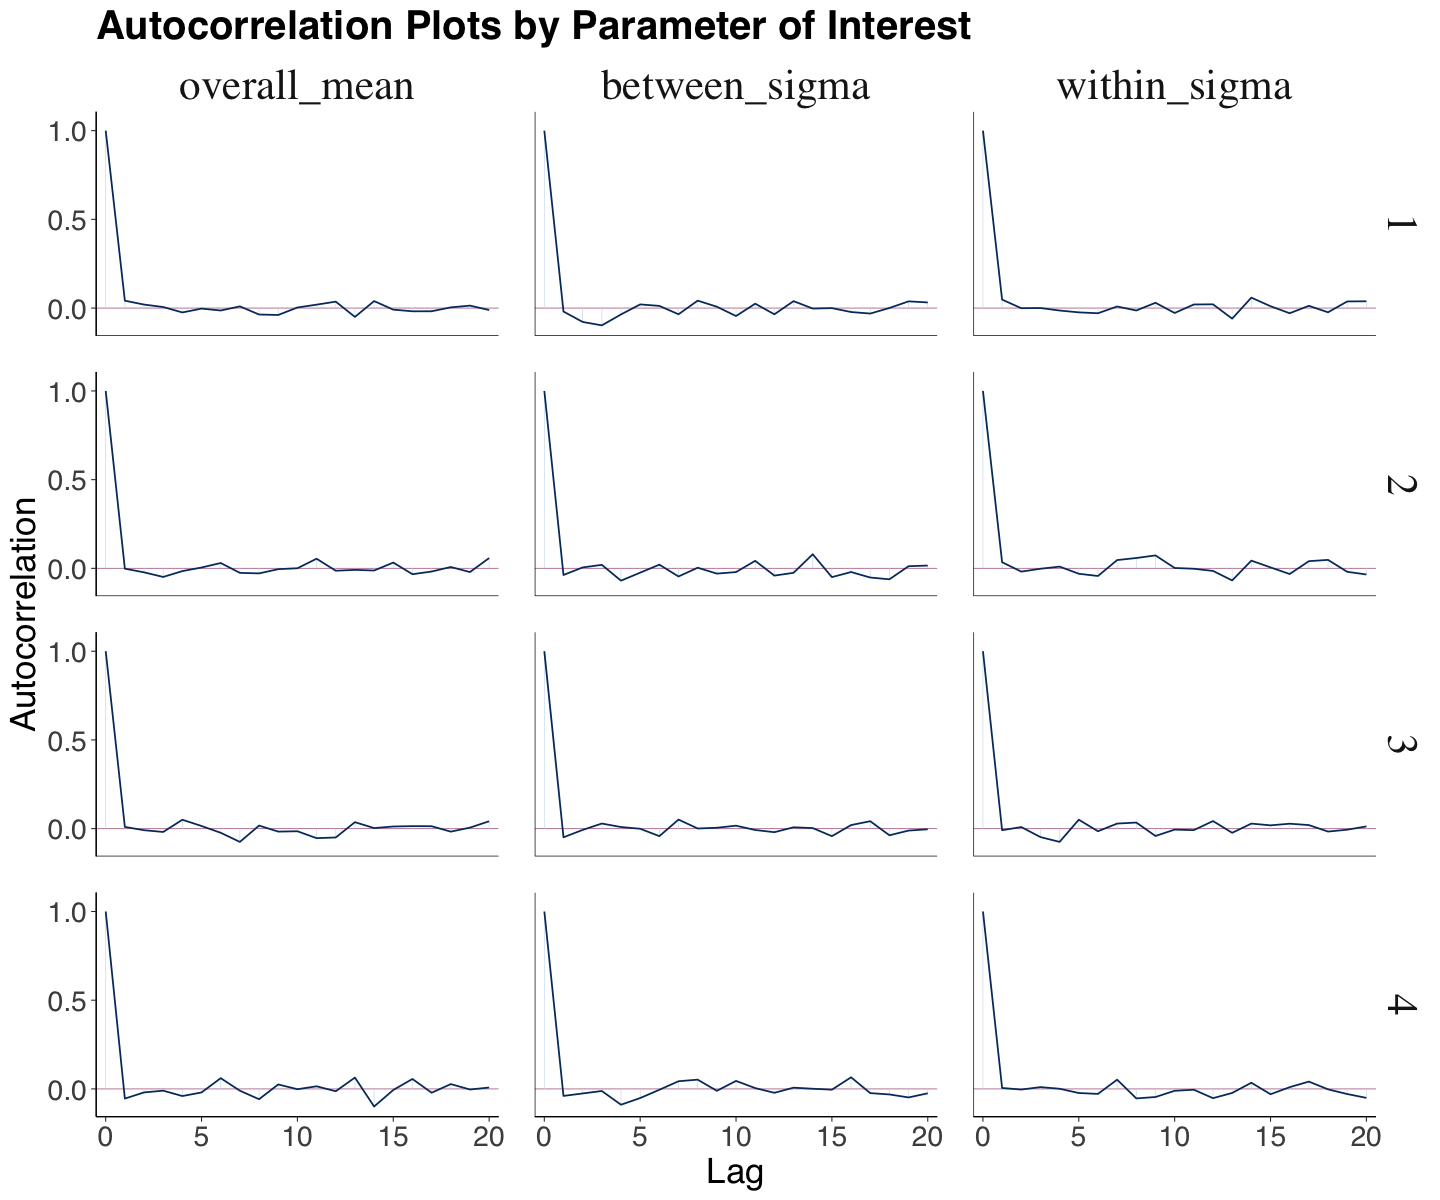

In [25]:
lag_4_chains

### 3.5. The Gelman-Rubin Diagnostic

To evaluate within and between-chain sampling variability, we can use the Gelman-Rubin diagnostic known as $\hat{R}$. The intuition is that if our MCMC algorithm is working well, and if we run multiple copies of our chain, then they should all give us roughly the same answer. 

In particular, **we check that quantities related to the variance within each chain and variance between chains are roughly the same**.

For a given parameter $\theta$ of interest, for which we run an MCMC simulation with $C$ chains, we let $\text{Var}_{\text{combined}}$ be the variabilty in the posterior samples of $\theta$ across our $C$ chains all combined and $\text{Var}_{\text{within}}$ the average variability in the posterior samples of $\theta$ in a standalone chain. The metric $\hat{R}$ is the following:

$$ 
\hat{R} \approx \sqrt{\frac{\text{Var}_{\text{combined}}}{\text{Var}_{\text{within}}}}. 
$$

**Per parameter in our MCMC simulation**, a given value of $\hat{R}$ indicates the following:

- $\hat{R} \approx 1$ indicates stability across the $C$ chains.
- $\hat{R} > 1$ indicates instability in the variability across all combined chains when compared to the average variability in a standalone chain.

We can automatically obtain this metric by parameter via `rhat()` from `bayesplot`.

In [26]:
spotify_r_hats <- rhat(posterior_spotify_4_chains,
  pars = c(
    "overall_mean",
    "between_sigma",
    "within_sigma"
  )
)
round(spotify_r_hats, 3)

overall_mean between_sigma  within_sigma 
        1.000         1.000         1.001

We do not have any major concerns regarding this metric for the Spotify case. We can also plot them via `mcmc_rhat()`.

In [27]:
r_hats_4_chains <- mcmc_rhat(spotify_r_hats, size = 2) +
  ggtitle("Gelman-Rubin Diagnostic by Parameter of Interest") +
  theme(
    plot.title = element_text(size = 24, face = "bold", family = "sans"),
    axis.text = element_text(size = 17, family = "sans"),
    axis.title = element_text(size = 21, family = "sans"),
    legend.text = element_text(size = 17, family = "sans"),
    legend.title = element_text(size = 17, family = "sans")
  ) +
  facet_text(size = 26)

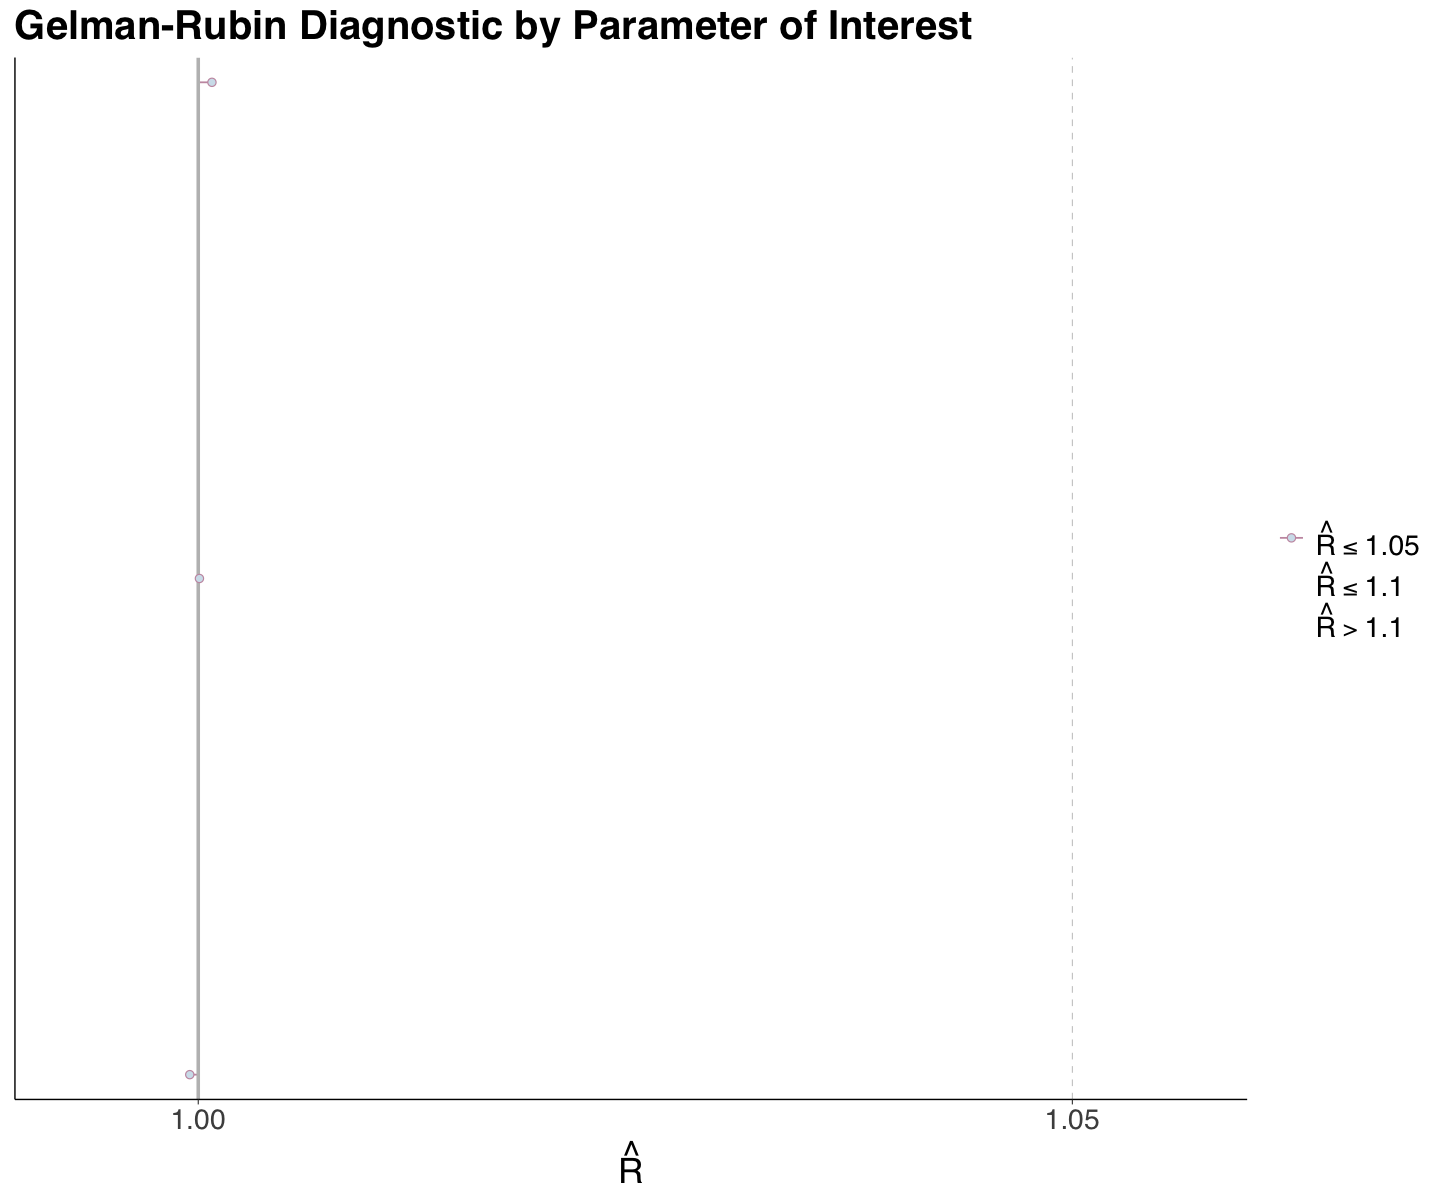

In [28]:
r_hats_4_chains

```{exercise}
:label: lecture8-q3

Suppose you ran $C$ chains ($C > 1$) and have ensured all MCMC diagnostics are OK for all your parameters of interest.

What shall we do with all the resulting posterior samples, coming from all $C$ chains, when drawing our final inferential conclusions?
```

## 4. Wrapping Up

- Well, this is the end of a pretty interesting Bayesian journey (for now, in MDS). 
- Throughout these weeks, we have explored a new way of performing inference and prediction (sometimes via regression models) using foundational probability concepts and simulations. Priors, likelihood, and posteriors are always a must here.
- The Bayesian paradigm is a vast field in Statistics and Machine Learning. You have the foundational tools to dig more into it from now on.